In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm

import datetime,pickle


#Import your modules
#---------------------------------------
import admin_functions as adfn
import cell_decomp_func as cdfn

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/sphere/dburrows12/'
s_data = '/sphere/dburrows12/'

%load_ext autoreload
sys.version

'3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]'

In [32]:
# CPMs
#Define parameters of simulated data
n_clusts = 5
n_genes = 800
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
per = 55 #percentage of dropped genes
e_std= 20 #spot + gene noise
g_std = 0 #gene specific noise
a_std = 0 #spot specific noise

In [33]:
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']
prop_vec = spot_sim.__dict__['prop_vec']

#Dropout a certain percentage of genes
# for i in range(spots.shape[0]):
#     rand_ind = np.random.choice(np.arange(spots.shape[1]), size = int((per/100) * spots.shape[1]), replace=False) #random index for selecting
#     spots[i,rand_ind]=0
spots = spots+np.random.exponential(e_std, (spots.shape))


#spots = spots.astype(int) 
#spots[spots < 0] = 0
#spots +=1 #remove any zeros

Loaded parameters: 5 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 33 spots.


In [34]:
#Simple Linear regression

with pm.Model(coords={"celltypes": np.arange(n_clusts),
                      "spots": np.arange(n_spots),
                      "genes": np.arange(n_genes) }) as basic_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

In [35]:
#Run model
with basic_model:
    basic_data=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 41 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


0.9916461995259853


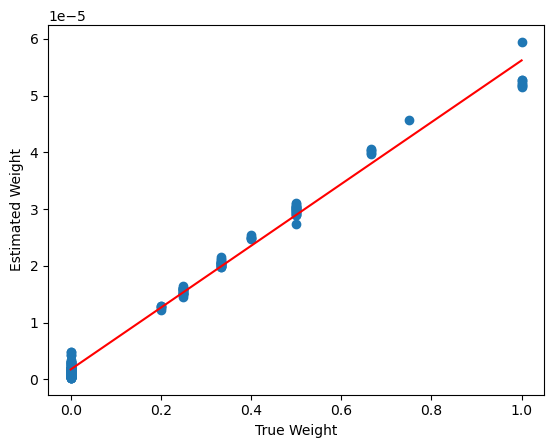

In [26]:
idata = basic_data
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
print(line_fit.rvalue**2)
plt.show()

0.9483413695634433


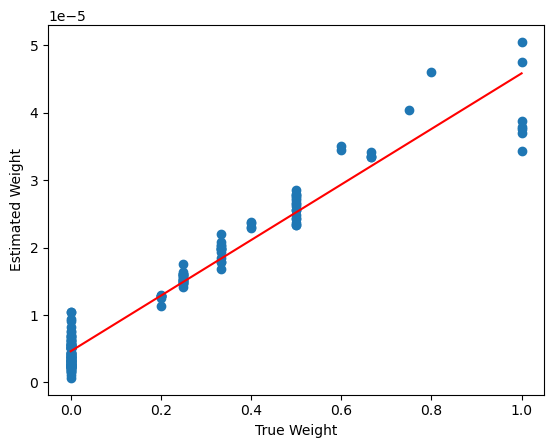

In [36]:
idata = basic_data
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
print(line_fit.rvalue**2)
plt.show()

In [37]:
#Poisson noise
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                      "spots": np.arange(n_spots),
                      "genes": np.arange(n_genes),
                       "1": np.arange(1) }) as Poisson_noise_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    eps=pm.Exponential("eps", lam=1/e_std, dims=['spots', 'genes']) # random noise at each spot and gene
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes']) # celltype proportions
    #alpha = pm.Normal("alpha", mu=0, sigma=0.1, dims=['spots','1']) # random noise at each spot
    #gamma = pm.Normal("gamma", mu= 0, sigma=0.1, dims=['1', 'genes']) # random noise at each gene

    lmd= pm.Deterministic('lmd', np.exp(eps)*pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

In [38]:
with Poisson_noise_model:
    idata = pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)


Sampling 1 chain for 782 tune and 0 draw iterations (782 + 0 draws total) took 2631 seconds.
/home/dburrows/anaconda3/envs/pymc_conda/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (782) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


0.9534645323469402


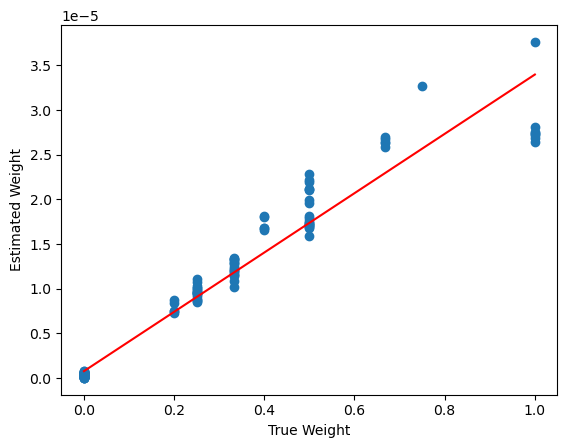

In [25]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
print(line_fit.rvalue**2)
plt.show()

0.5883434284525507


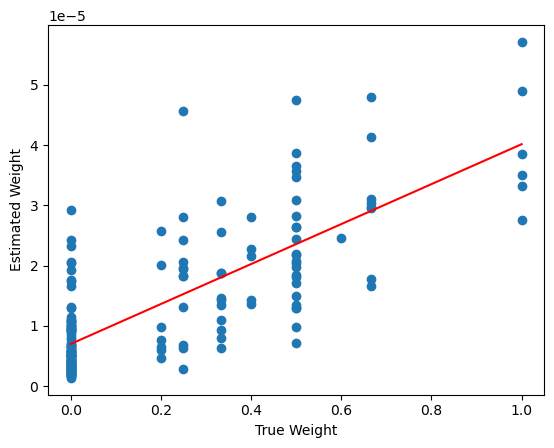

In [14]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
print(line_fit.rvalue**2)
plt.show()

In [36]:
rng = np.random.default_rng(1)
def my_negbinom(m,overdispersion=1,rng=rng):  
    v = 1+m*overdispersion
    p=m/v
    n=m*m/(v-m)
    y=rng.negative_binomial(n=n,p=p)
    return y

In [37]:
# Simulate data
smoke_test=False

if smoke_test:
    C=4   # Cells
    S=20  # Visium sites
    G=100  # Genes
else:
    C=30   # Cells
    S=300  # Visium sites
    G=5000  # Genes

N,Nref=100,10       # Scaling factor for total library size for Visium and for cell type reference
rho=0.1 # Fraction of independent variation in cell type gene expression
r=4 # Dispersion parameter for negative binomial counts

# Cell type gene expression. For most genes, the gene expression is strongly correlated
# across all cell types. The expression level is the sum of a a shared component (0.9)
# and an independent component (0.1)
x = rng.exponential((1-rho)*N,size=(1,G))+rng.exponential(rho*N,size=(C,G))

# For a small fraction of genes (e.g. 5%), the gene expression is completely uncorrelated across cell types
Gde = int(0.2*G) # Fraction of DE genes
x[:,:Gde] = rng.exponential(N,size=(C,Gde))

# Weights of each cell type at each site. Interpret this as the number of cells of each type that show up
# at each site.
mu_cell = rng.exponential(2/C,size=(C)) # Mean number of cells at each site
W=my_negbinom(np.tile(mu_cell, (S,1)))

# Gene expression at each site
bgd = 10
mu_site=bgd+(W@x)
y=my_negbinom(mu_site)

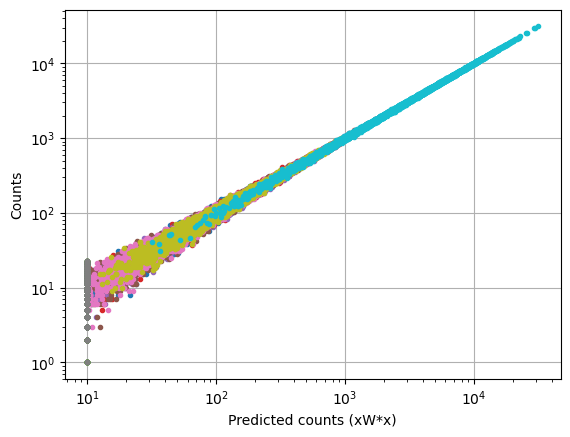

In [4]:
plt.loglog(mu_site[:10].T, y[:10].T,'.');
plt.xlabel('Predicted counts (xW*x)')
plt.ylabel('Counts')
plt.grid()

In [45]:
#Simple Linear regression

with pm.Model(coords={"celltypes": np.arange(C),
                      "spots": np.arange(S),
                      "genes": np.arange(G) }) as basic_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', x, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    #N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd, observed=y)

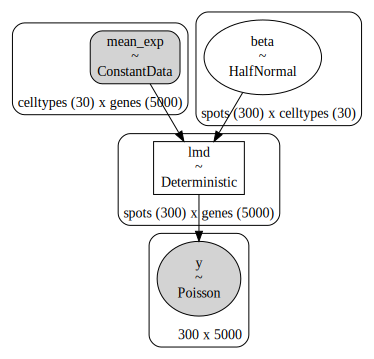

In [47]:
pm.model_to_graphviz(basic_model)

In [49]:
with basic_model:
    idata = pm.sample(random_seed=1,tune=100,draws=200,discard_tuned_samples=False)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 67 tune and 0 draw iterations (268 + 0 draws total) took 766 seconds.


In [35]:
with pm.Model(coords={"cells":np.arange(C),
                      "genes":np.arange(G),
                      "sites":np.arange(S)}) as model:
    # Priors for unknown model parameters

    x_data=pm.Data('x_data',x,shape=(C,G),mutable=False,dims=['cells','genes'])
    
    mu_cell = pm.TruncatedNormal("mu_cell",mu=1,sigma=1,lower=0,dims=["cells"])
    # sigma_rho = pm.TruncatedNormal("sigma_rho",mu=1,sigma=1,lower=0,
    #                             shape=(C),dims=["cells"])    
    W = pm.TruncatedNormal("W",mu=mu_cell,sigma=mu_cell,lower=0,dims=["sites","cells"])
    
    bgd = pm.Exponential('bgd',lam=1)    # background counts
    # bgd = 0    # background counts

    # Expected value of outcome
    mu = pm.Deterministic("mu", bgd+pm.math.dot(W,x_data), dims=["sites","genes"])

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.NegativeBinomial("Y_obs",mu=mu,alpha=r,observed=y,dims=['sites','genes'])
#     sigma=pm.Exponential('sigma', lam=1)
#     Y_obs = pm.Normal("Y_obs",mu=mu,sigma=sigma,observed=y, dims=["sites","genes"])

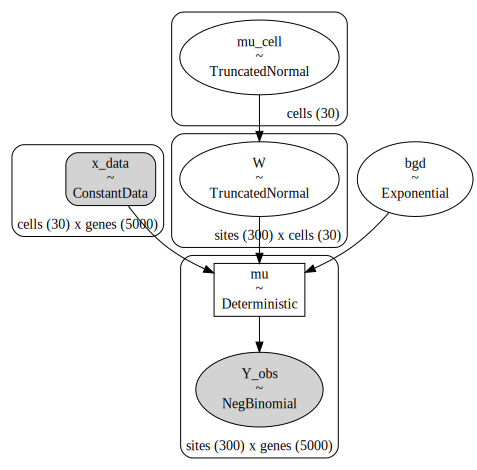

In [14]:
pm.model_to_graphviz(model)